# Train U-Net on multiclass problems

This is very similar code to `11_unet_carvana.ipynb` but we have 2 classes instead of 1.

With approximately 300 images, I trained for 100 epochs and got decent results.

With augmentation, it takes 30 epochs before the model start to light up pixels that are part of the mask. Without augmentation, it takes approximately 10 epochs.

In [1]:
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
from  torchvision.transforms import ToTensor,Resize, Normalize
from tqdm import tqdm
from torch import optim
from multiClassUNetDataset import MultiClassUNetDataset
from unet import Unet
import torch.nn as nn
from datetime import datetime
import albumentations as A
import cv2
from trackingProject import TrackingProject

In [2]:
project = TrackingProject(name="faceTrack",root_folder = "/home/kevin/Documents/trackingProjects/")

Project directory: /home/kevin/Documents/trackingProjects/faceTrack
Loading /home/kevin/Documents/trackingProjects/faceTrack/config.yalm
{'augmentation_HorizontalFlipProb': 0.0, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_size': [480, 640], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'faceTrack', 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0), (128.0, 0.0, 128.0)], 'objects': ['nose', 'chin', 'rEye', 'lEye'], 'target_radius': 10}


In [3]:
train_images_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/train_images"
train_masks_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/train_masks"
train_coordinates_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/train_coordinates"
val_images_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/val_images"
val_masks_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/val_masks"
val_coordinates_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/val_coordinates"

In [4]:
original_height = project.image_size[0]
original_width = project.image_size[1]
transform = A.Compose([   
                    A.RandomSizedCrop(min_max_height=(original_height-50, original_height),w2h_ratio=original_width/original_height,height=original_height, width=original_width, p=project.augmentation_RandomSizedCropProb),
                    A.HorizontalFlip(p=project.augmentation_HorizontalFlipProb),
                    A.Rotate (limit=30,border_mode=cv2.BORDER_CONSTANT,p=project.augmentation_RotateProb),
                    A.RandomBrightnessContrast(p=project.augmentation_RandomBrightnessContrastProb)])
print(transform)

Compose([
  RandomSizedCrop(always_apply=False, p=1.0, min_max_height=(430, 480), height=480, width=640, w2h_ratio=1.3333333333333333, interpolation=1),
  HorizontalFlip(always_apply=False, p=0.0),
  Rotate(always_apply=False, p=0.3, limit=(-30, 30), interpolation=1, border_mode=0, value=None, mask_value=None, rotate_method='largest_box', crop_border=False),
  RandomBrightnessContrast(always_apply=False, p=0.2, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


In [5]:
trainDataset = MultiClassUNetDataset(image_dir=train_images_dir, mask_dir=train_masks_dir,coordinates_dir=train_coordinates_dir,transform = transform )
len(trainDataset)

368

In [6]:
valDataset = MultiClassUNetDataset(image_dir=val_images_dir, mask_dir=val_masks_dir,coordinates_dir=val_coordinates_dir)
len(valDataset)

65

In [7]:
img, mask , coord= trainDataset[24]

img.shape,mask.shape,coord.shape

(torch.Size([3, 480, 640]), torch.Size([4, 480, 640]), (4, 2))

torch.Size([4, 480, 640]) torch.Size([3, 480, 640]) tensor(1.)


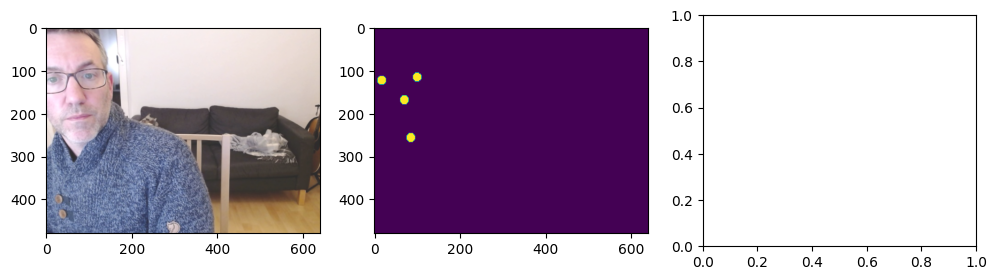

In [8]:
print(mask.shape,img.shape,mask.max())
fig,ax = plt.subplots(1,3,figsize=(12,3))
ax[0].imshow(img.permute(1,2,0))
ax[1].imshow(mask.permute(1,2,0)[:,:,:].sum(axis=2))



In [9]:
BATCH_SIZE=2
trainLoader = DataLoader(trainDataset,
                          shuffle=True,
                          batch_size=BATCH_SIZE,
                          num_workers=4)
valLoader = DataLoader(valDataset,
                          shuffle=False,
                          batch_size=BATCH_SIZE,
                          num_workers=4)

In [10]:
imgs, masks, _ = next(iter(trainLoader))
imgs.shape, masks.shape

(torch.Size([2, 3, 480, 640]), torch.Size([2, 4, 480, 640]))

## Device

In [11]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print("Training on device {}".format(device))

Training on device cuda


## Model

In [12]:
model = Unet(in_channels=3,out_channels=len(project.object_list)).to(device)

In [13]:
out = model(imgs.to(device))
out.shape

torch.Size([2, 4, 480, 640])

# Save and load checkpoint

In [14]:
def save_checkpoint(state, filename = "my_checkpoint.pth.tar"):
    #print("Saving checkpoint")
    torch.save(state,filename)
def load_checkpoint(checkpoint, model):
    print("Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

## Check accuracy

In [15]:
def check_accuracy(loader,model,device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    with torch.no_grad():
        for x,y, _ in loader:
            x = x.to(device)
            y = y.to(device)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2*(preds * y).sum() / ((preds+y).sum() + 1e-8)) # work only for binary
            
            # proportion of the mask detected
            num_mask = y.sum()
            num_mask_detected = preds[y==1.0].sum()
            num_detected = preds.sum()
                        
    print(f"Accuracy: {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader):.2f}")
    print(f"Mask pixels detected: {num_mask_detected/num_mask*100:.2f}%")
    print(f"False positives: {(num_detected-num_mask_detected)/num_detected*100:.2f}%")
    model.train()     

## Save predictions

In [16]:
import torchvision

In [17]:
def save_predictions_as_imgs(loader, model, folder = "saved_images/",device="cuda"):
    model.eval()
    for idx, (x,y,_) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(preds.sum(axis=1).unsqueeze(1), f"{folder}/pred_{idx}.png")
        
        torchvision.utils.save_image(y.sum(axis=1).unsqueeze(1), f"{folder}/original_{idx}.png")
    model.train()
    


## Hyperparameters


In [18]:
LEARNING_RATE=1e-4
DEVICE = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")) 
BATCH_SIZE=4
NUM_EPOCHS = 60
NUM_WORKERS = 4
OUTPUT_CHANNELS = len(project.object_list)
IMAGE_HEIGHT = 480
IMAGE_WIDTH = 640 
PIN_MEMORY = True
LOAD_MODEL = True
TRAIN_IMG_DIR ="/home/kevin/Documents/trackingProjects/faceTrack/dataset/train_images"
TRAIN_MASK_DIR ="/home/kevin/Documents/trackingProjects/faceTrack/dataset/train_masks" 
TRAIN_COORDINATES_DIR ="/home/kevin/Documents/trackingProjects/faceTrack/dataset/train_coordinates" 
VAL_IMG_DIR = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/val_images"
VAL_MASK_DIR ="/home/kevin/Documents/trackingProjects/faceTrack/dataset/val_masks"
VAL_COORDINATES_DIR ="/home/kevin/Documents/trackingProjects/faceTrack/dataset/val_coordinates"

## Training loop

In [19]:
def train_fn(loader,model,optimizer,loss_fn,scaler,epoch,total_epochs):
    """
    One epoch of training
    """
    loop = tqdm(loader)
    for batch_idx, (data,targets,_) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.to(device=DEVICE)
        
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions,targets)
            
        
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # update tqdm loop
        loop.set_postfix_str("loss: {:.7f}, epoch: {:d}/{:d}".format(loss.item(),epoch,total_epochs))

 


In [20]:
print(transform)
model = Unet(in_channels=3, out_channels=OUTPUT_CHANNELS).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss() # not doing sigmoid on the output of the model, so use this, if we had more classes (objects) we would use change out_chan and cross_entropy_loss as loss_fn
optimizer= optim.Adam(model.parameters(),lr=LEARNING_RATE)

trainDataset = MultiClassUNetDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR,TRAIN_COORDINATES_DIR, transform=transform)
valDataset = MultiClassUNetDataset(VAL_IMG_DIR, VAL_MASK_DIR,VAL_COORDINATES_DIR, transform=None)
trainLoader = DataLoader(trainDataset,shuffle=True,batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,pin_memory=PIN_MEMORY)
valLoader = DataLoader(valDataset,shuffle=False,batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,pin_memory = PIN_MEMORY)

if LOAD_MODEL:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

scaler = torch.cuda.amp.GradScaler()


Compose([
  RandomSizedCrop(always_apply=False, p=1.0, min_max_height=(430, 480), height=480, width=640, w2h_ratio=1.3333333333333333, interpolation=1),
  HorizontalFlip(always_apply=False, p=0.0),
  Rotate(always_apply=False, p=0.3, limit=(-30, 30), interpolation=1, border_mode=0, value=None, mask_value=None, rotate_method='largest_box', crop_border=False),
  RandomBrightnessContrast(always_apply=False, p=0.2, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})
Loading checkpoint


In [21]:
startTime = datetime.now()
print("Starting time:",startTime)
for epoch in range(NUM_EPOCHS):
    train_fn(trainLoader,model,optimizer,loss_fn,scaler,epoch,NUM_EPOCHS)
    
    if epoch % 5 == 0 :
        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict()}
        save_checkpoint(checkpoint)

        # check accuracy
        check_accuracy(valLoader,model,device=DEVICE)

        # print example image to folder
        save_predictions_as_imgs(valLoader, model, device=DEVICE)

endTime=datetime.now()
print("End time:",endTime)
print("{} epochs, duration:".format(NUM_EPOCHS), endTime-startTime)

Starting time: 2022-11-24 22:45:24.434358


100%|█████████████| 92/92 [00:20<00:00,  4.40it/s, loss: 0.0007224, epoch: 0/60]


Accuracy: 99.97
Dice score: 0.87
Mask pixels detected: 87.87%
False positives: 14.58%


100%|█████████████| 92/92 [00:20<00:00,  4.46it/s, loss: 0.0006392, epoch: 5/60]


Accuracy: 99.97
Dice score: 0.87
Mask pixels detected: 93.77%
False positives: 8.84%


100%|████████████| 92/92 [00:20<00:00,  4.48it/s, loss: 0.0004802, epoch: 10/60]


Accuracy: 99.97
Dice score: 0.87
Mask pixels detected: 93.20%
False positives: 15.15%


100%|████████████| 92/92 [00:20<00:00,  4.47it/s, loss: 0.0003966, epoch: 15/60]


Accuracy: 99.97
Dice score: 0.86
Mask pixels detected: 88.69%
False positives: 13.58%


100%|████████████| 92/92 [00:20<00:00,  4.47it/s, loss: 0.0005567, epoch: 20/60]


Accuracy: 99.97
Dice score: 0.86
Mask pixels detected: 92.79%
False positives: 15.46%


100%|████████████| 92/92 [00:20<00:00,  4.39it/s, loss: 0.0003982, epoch: 25/60]


Accuracy: 99.97
Dice score: 0.86
Mask pixels detected: 88.36%
False positives: 13.27%


100%|████████████| 92/92 [00:20<00:00,  4.40it/s, loss: 0.0005377, epoch: 30/60]


Accuracy: 99.97
Dice score: 0.85
Mask pixels detected: 88.61%
False positives: 11.83%


100%|████████████| 92/92 [00:20<00:00,  4.39it/s, loss: 0.0003689, epoch: 35/60]


Accuracy: 99.97
Dice score: 0.85
Mask pixels detected: 88.44%
False positives: 14.57%


100%|████████████| 92/92 [00:20<00:00,  4.40it/s, loss: 0.0004138, epoch: 40/60]


Accuracy: 99.97
Dice score: 0.85
Mask pixels detected: 95.66%
False positives: 14.63%


100%|████████████| 92/92 [00:20<00:00,  4.41it/s, loss: 0.0006420, epoch: 45/60]


Accuracy: 99.97
Dice score: 0.85
Mask pixels detected: 89.84%
False positives: 16.53%


100%|████████████| 92/92 [00:20<00:00,  4.45it/s, loss: 0.0003899, epoch: 50/60]


Accuracy: 99.97
Dice score: 0.85
Mask pixels detected: 87.46%
False positives: 17.35%


100%|████████████| 92/92 [00:20<00:00,  4.45it/s, loss: 0.0003819, epoch: 55/60]


Accuracy: 99.97
Dice score: 0.85
Mask pixels detected: 87.70%
False positives: 15.88%


100%|████████████| 92/92 [00:20<00:00,  4.47it/s, loss: 0.0005183, epoch: 59/60]

End time: 2022-11-24 23:07:37.610473
60 epochs, duration: 0:22:13.176115


In [22]:
project.save_model(model)

saving model state dict to /home/kevin/Documents/trackingProjects/faceTrack/models/UNet.pt
2022-11-24 23:07:37.617228
